In [2]:
import tarfile
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras import metrics, Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Input, Add, BatchNormalization, Dropout, Reshape, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam, Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
import h5py
import matplotlib.pyplot as plt

In [2]:
tar = tarfile.open("./RML2016.10a.tar.bz2", "r:bz2")  
tar.extractall()

In [3]:
with open("RML2016.10a_dict.pkl", "rb") as p:
    dataset = pickle.load(p, encoding='latin1')

In [4]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1,0])

In [5]:
X = []  
labels = []

In [6]:
for mod in mods:
    for snr in snrs:
        X.append(dataset[(mod,snr)])
        for i in range(dataset[(mod,snr)].shape[0]):  
            labels.append((mod,snr))

In [7]:
d = np.vstack(X)

raw = d
derivative = np.gradient(d, axis=-1)
fft = np.abs(np.fft.fft(d, axis=-1))
fft_deriv = np.abs(np.fft.fft(np.gradient(d, axis=-1), axis=-1))

# Concatenate different forms of signal vectors
raw_fft = np.concatenate((raw, fft), axis=-1)
raw_fft_deriv = np.concatenate((raw, fft, fft_deriv), axis=-1)

In [8]:
data = raw
# data = derivative
# data = raw_fft
# data = raw_fft_deriv

In [9]:
np.random.seed(2016)
n_examples = data.shape[0]
n_train = n_examples * 0.8
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = data[train_idx]
X_test =  data[test_idx]

In [10]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [11]:
Y_train = to_onehot(list(map(lambda x: mods.index(labels[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(labels[x][0]), test_idx)))

In [12]:
inp_shape = list(X_train.shape[1:])
classes = mods

In [14]:
x = Input(shape=(2,128,1))
y = Conv2D(256, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
y = Dropout(0.6)(y)
y = Conv2D(256, (2, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(y)   
z = Add()([x, y])
z = Conv2D(80, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(z)
z = Dropout(0.6)(z)
z = Conv2D(80, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform')(z)
z = Dropout(0.6)(z)
zz = Flatten()(z)
z = Dense(128, activation='relu', kernel_initializer='he_normal')(zz)
z = Dropout(0.6)(z)
z = Dense(11, activation='softmax', kernel_initializer='he_normal')(z)
model = Model(x,z)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 128, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 2, 128, 256)  1024        ['input_2[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2, 128, 256)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 2, 128, 256)  393472      ['dropout_4[0][0]']              
                                                                                            

In [15]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
checkpoint_filepath = "best_model.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True, verbose=0)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, min_delta=1e-4, mode='min')

In [17]:
history = model.fit(
    X_train,
    Y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoint_callback, reduce_lr_loss]
)

Epoch 1/15
1375/1375 [==============================] - 802s 583ms/step - loss: 2.0747 - accuracy: 0.2407 - val_loss: 1.8806 - val_accuracy: 0.3161 - lr: 1.0000e-04
Epoch 2/15
1375/1375 [==============================] - 833s 606ms/step - loss: 1.9079 - accuracy: 0.2921 - val_loss: 1.7603 - val_accuracy: 0.3582 - lr: 1.0000e-04
Epoch 3/15
1375/1375 [==============================] - 836s 608ms/step - loss: 1.8062 - accuracy: 0.3241 - val_loss: 1.6257 - val_accuracy: 0.4060 - lr: 1.0000e-04
Epoch 4/15
1375/1375 [==============================] - 849s 617ms/step - loss: 1.7133 - accuracy: 0.3610 - val_loss: 1.5454 - val_accuracy: 0.4294 - lr: 1.0000e-04
Epoch 5/15
1375/1375 [==============================] - 851s 619ms/step - loss: 1.6400 - accuracy: 0.3883 - val_loss: 1.4918 - val_accuracy: 0.4446 - lr: 1.0000e-04
Epoch 6/15
1375/1375 [==============================] - 856s 622ms/step - loss: 1.5788 - accuracy: 0.4084 - val_loss: 1.4334 - val_accuracy: 0.4603 - lr: 1.0000e-04
Epoch 7/15

In [18]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_acc)

1375/1375 [==============================] - 74s 54ms/step - loss: 1.2869 - accuracy: 0.5112
Test accuracy: 0.5112272500991821


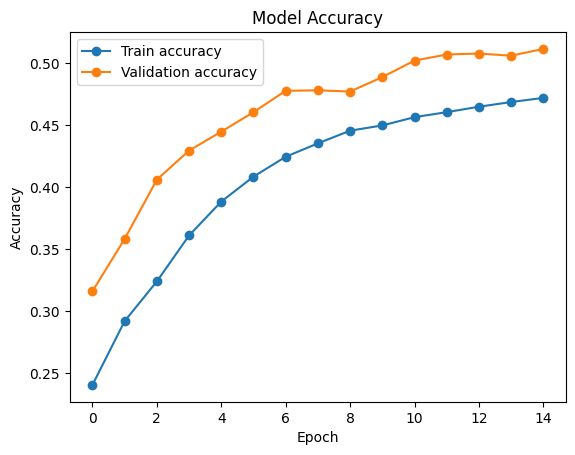

In [19]:
plt.plot(history.history["accuracy"], label = 'Train accuracy', marker='o')
plt.plot(history.history["val_accuracy"], label = 'Validation accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

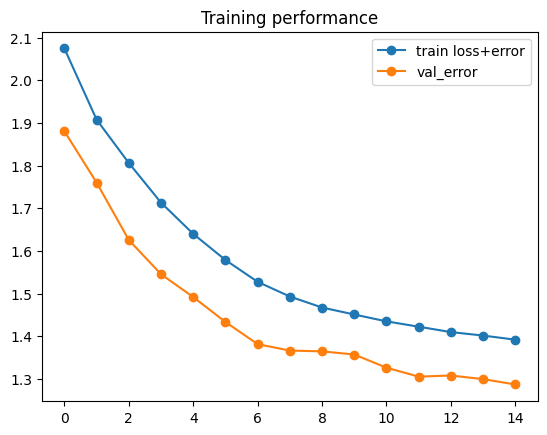

In [20]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error', marker='o')
plt.plot(history.epoch, history.history['val_loss'], label='val_error', marker='o')
plt.legend()

In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

23/23 [==============================] - 3s 145ms/step
Overall Accuracy for SNR=-20:  0.09611913357400723
23/23 [==============================] - 4s 155ms/step
Overall Accuracy for SNR=-18:  0.0926009986382206
22/22 [==============================] - 4s 161ms/step
Overall Accuracy for SNR=-16:  0.09484724122207022
22/22 [==============================] - 4s 161ms/step
Overall Accuracy for SNR=-14:  0.11167279411764706
23/23 [==============================] - 3s 136ms/step
Overall Accuracy for SNR=-12:  0.14164051994621246
23/23 [==============================] - 3s 137ms/step
Overall Accuracy for SNR=-10:  0.19667832167832167
21/21 [==============================] - 3s 131ms/step
Overall Accuracy for SNR=-8:  0.33
23/23 [==============================] - 3s 145ms/step
Overall Accuracy for SNR=-6:  0.4822631342613381
22/22 [==============================] - 3s 127ms/step
Overall Accuracy for SNR=-4:  0.6037914691943128
23/23 [==============================] - 4s 167ms/step
Overall Accu

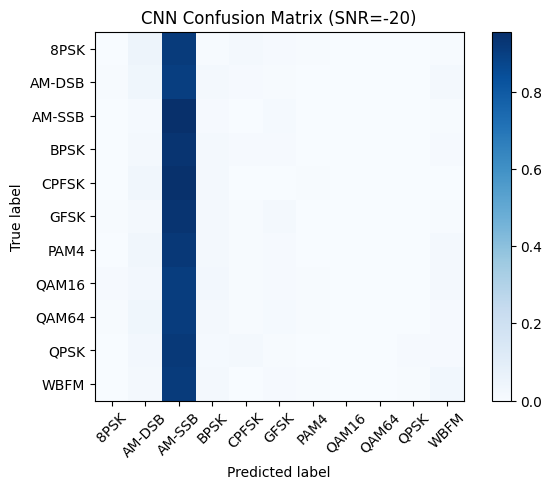

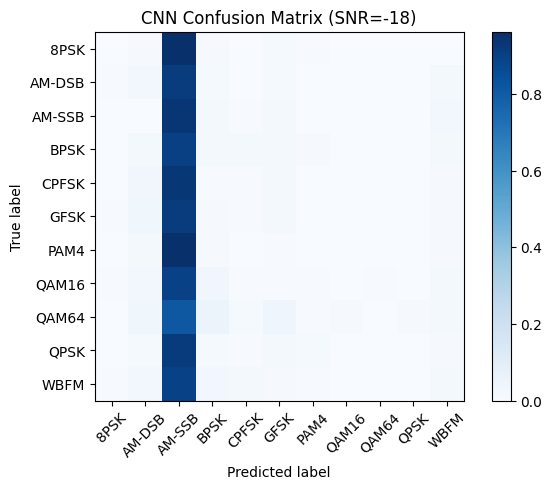

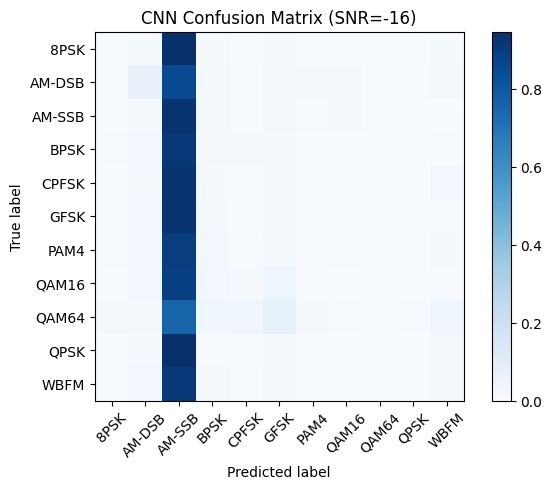

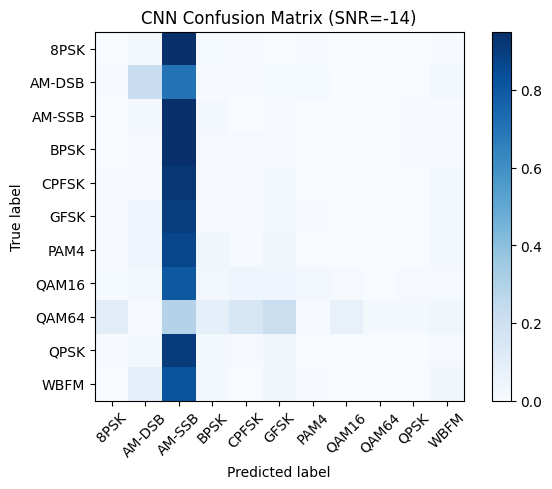

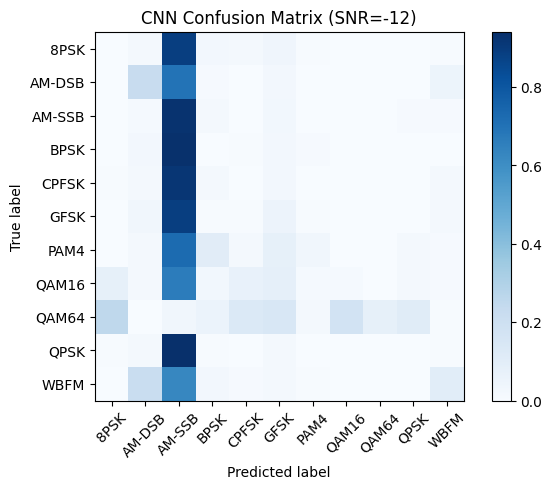

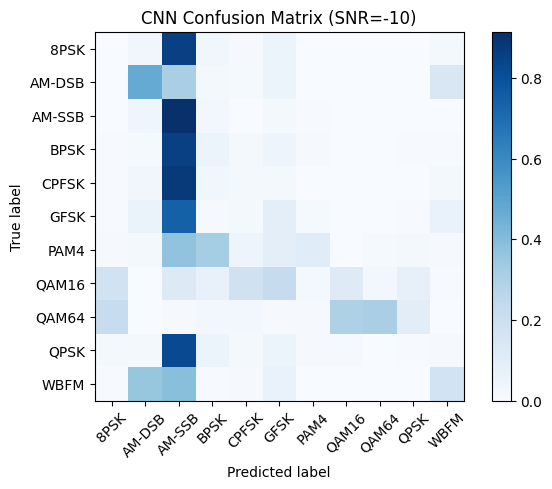

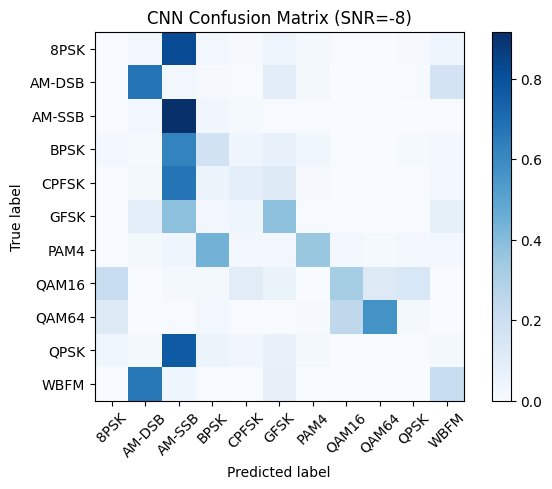

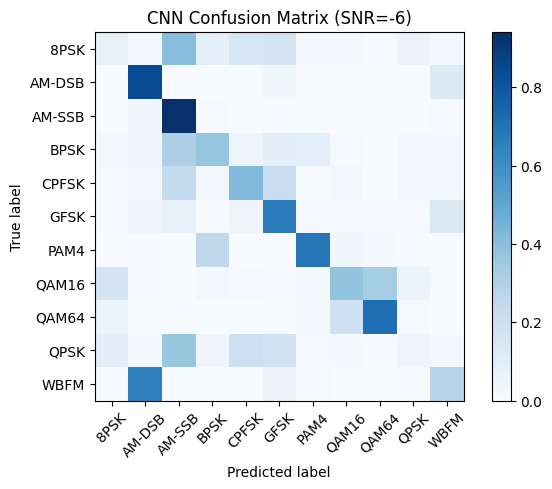

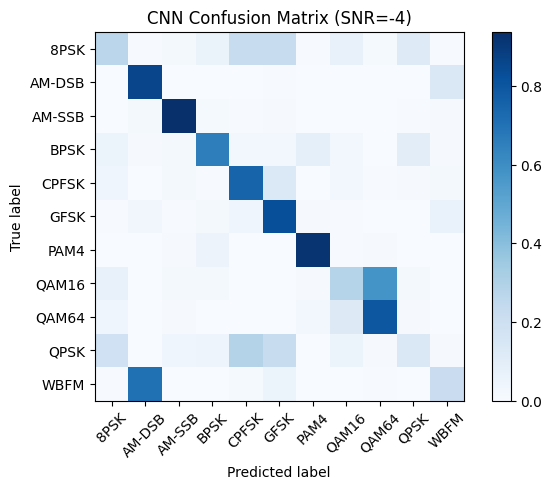

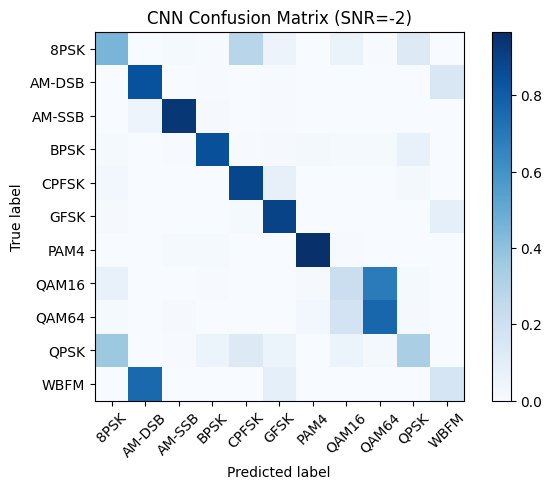

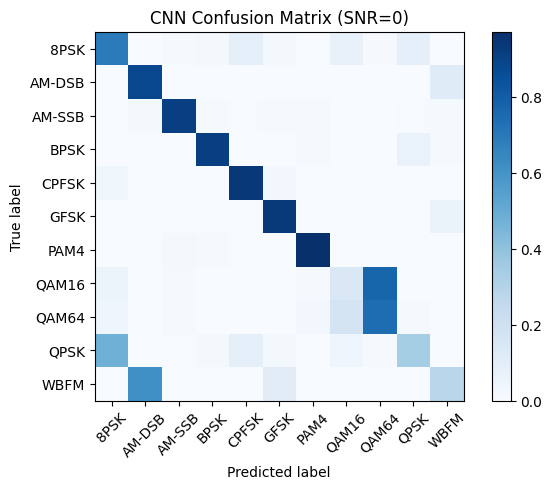

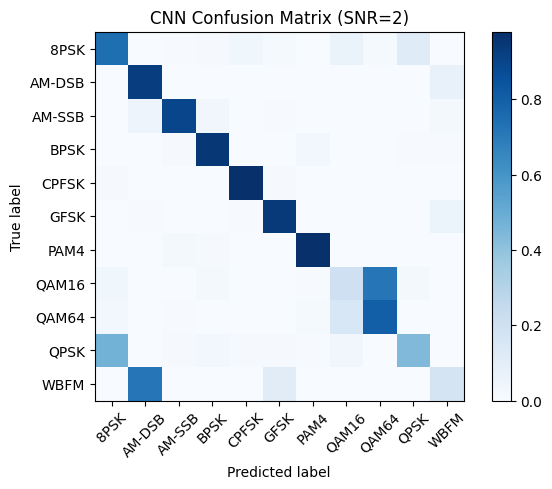

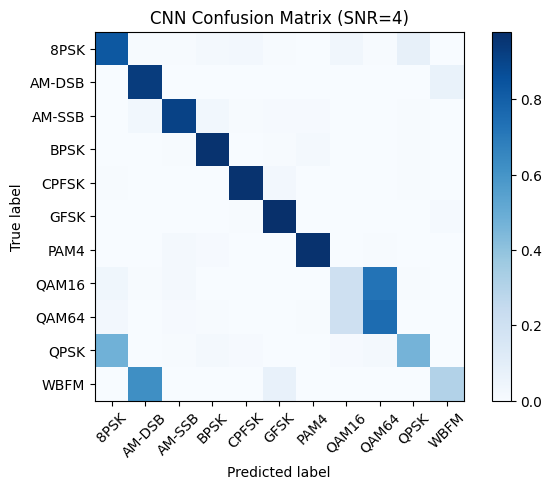

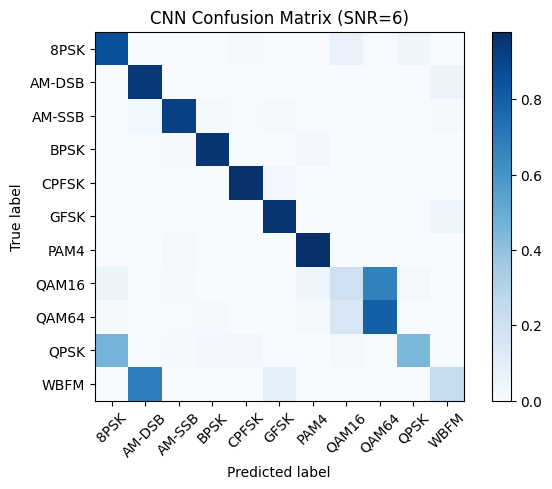

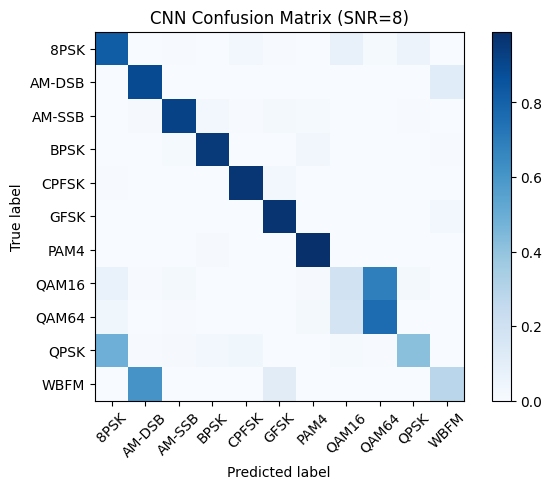

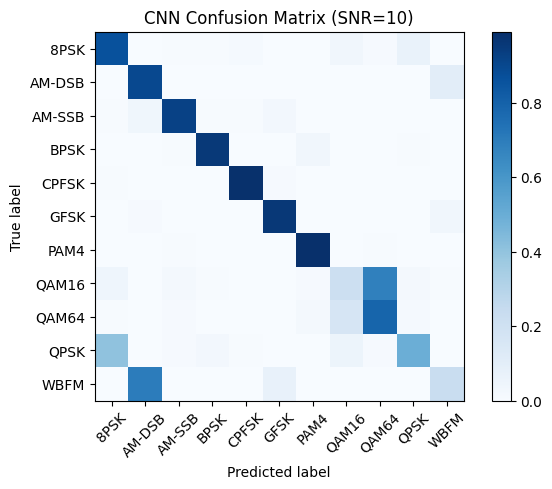

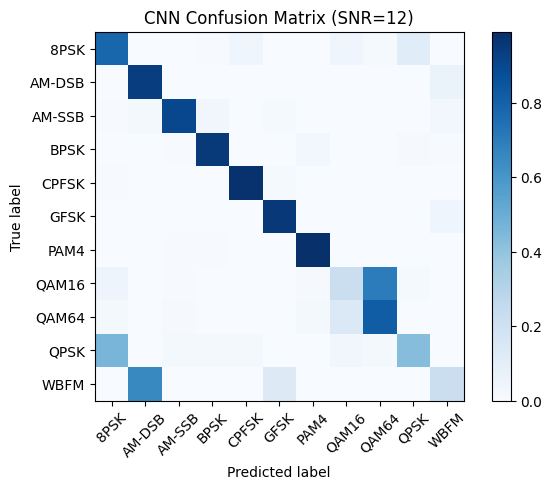

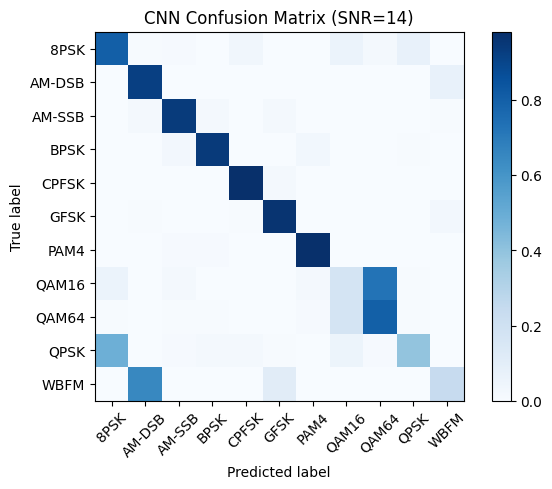

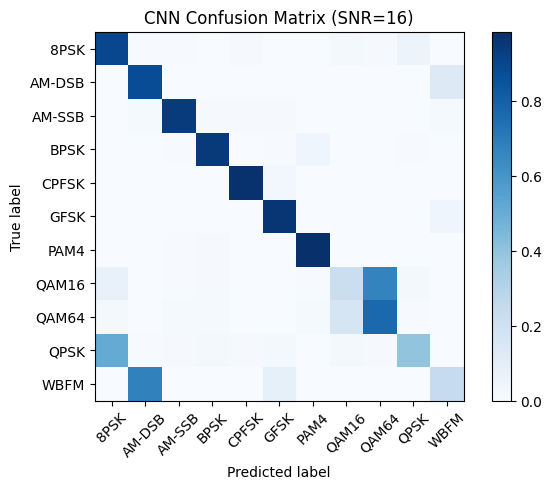

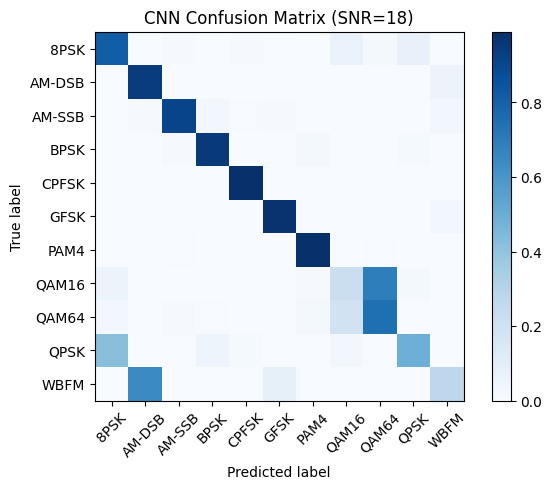

In [22]:
acc = {}
for snr in snrs:    
    test_SNRs = list(map(lambda x: labels[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_Y_hat = model.predict(test_X_i, batch_size=100)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="CNN Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy for SNR=%d: "%(snr), 1.0 * cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN Classification Accuracy')

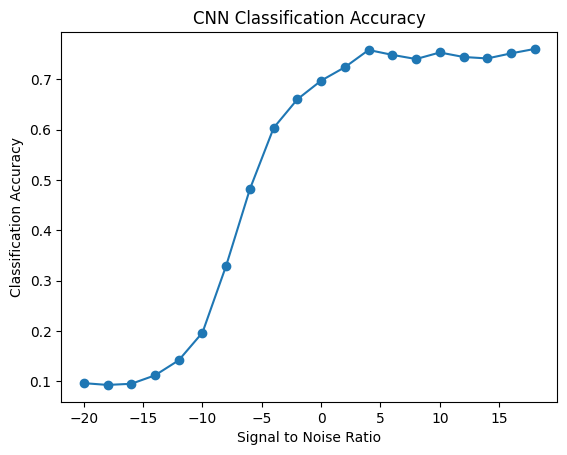

In [23]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)), marker='o')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN Classification Accuracy")